In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.rc = {'figure.figsize': (10,6)}
%matplotlib inline

## Fluid dynamics with SfePy

In this notebook we recreate one of the [SfePy examples](https://sfepy.org/doc-devel/examples/) using a mesh generated with Nanomesh.

The [original example](https://sfepy.org/doc-devel/examples/diffusion-laplace_fluid_2d.html), describes a Laplace equation that models the flow of “dry water” around an obstacle shaped like a Citroen CX. [Fluid dynamics](https://en.wikipedia.org/wiki/Fluid_dynamics) are commonly used to model air flow around an object. We don't have an image of a car, but let's see how far we get with modeling aero-dynamics of a [horse](https://en.wikipedia.org/wiki/Horse). :-)

Prerequisites:
- [Sfepy](https://sfepy.org/doc-devel/installation.html)
- [Mayavi](https://docs.enthought.com/mayavi/mayavi/installation.html) (optional, for one of the plots)


### Load data

This example uses the [skimage horse sample data](https://scikit-image.org/docs/stable/api/skimage.data.html#skimage.data.horse).

The data are inverted and small gaps in the tail are filled.

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


<AxesSubplot:title={'center':'Plane(shape=(328, 400), range=(0,1), dtype=int32)'}, xlabel='x', ylabel='y'>

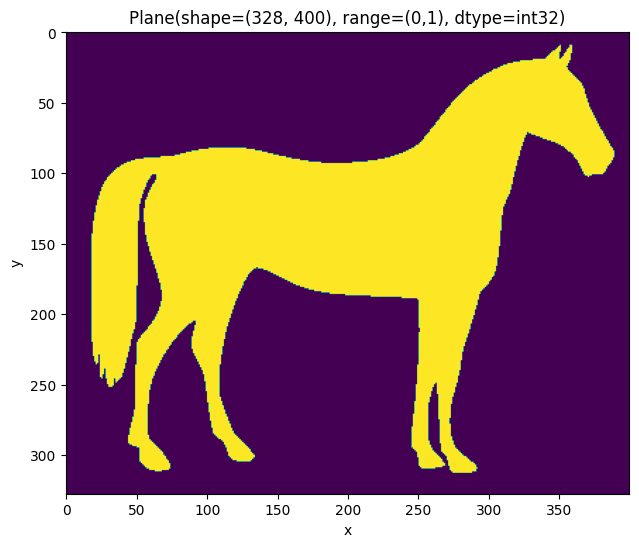

In [2]:
from skimage.data import horse
from nanomesh import Image
from scipy import ndimage as ndi

data = horse()

plane = Image(~data)
plane = plane.apply(ndi.binary_fill_holes).astype(int)

plane.show(title=plane)

### Generating the mesh

The shape of the object is simplified to reduce the number of triangles. Note that the bbox was expanded to leave some head/tail room for the partial derivatives.

(<AxesSubplot:title={'center':'line mesh'}>,
 <AxesSubplot:title={'center':'triangle mesh'}>)

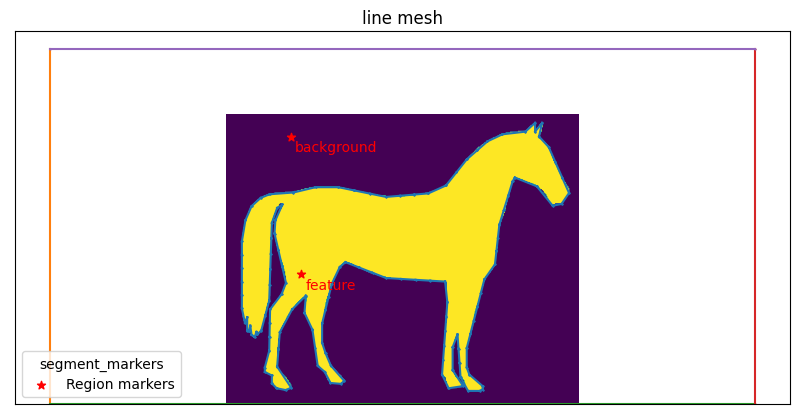

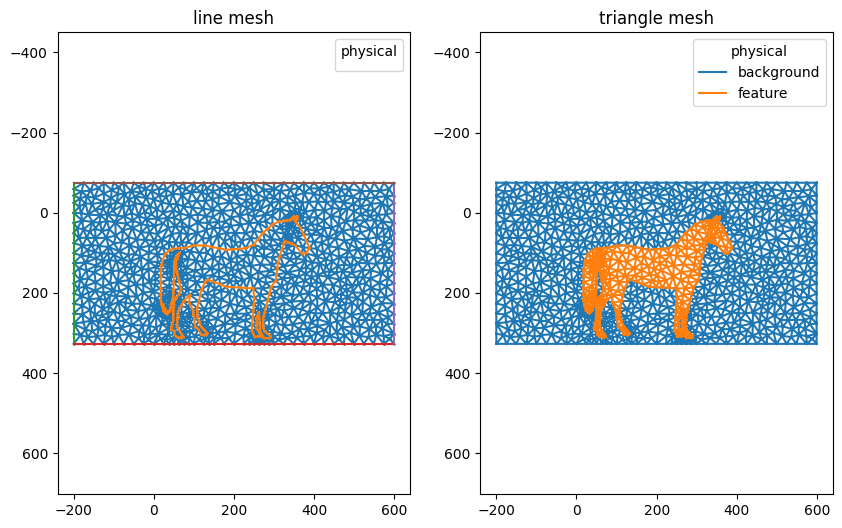

In [3]:
from nanomesh import Mesher

mesher = Mesher(plane)
mesher.bbox = [[  -75,   -200],
        [327,   -200],
        [327, 599],
        [  -75, 599]]
mesher.generate_contour(precision=2, max_edge_dist=15)
mesher.plot_contour()

nanomesh_mesh = mesher.triangulate(opts='pAq30a300')
nanomesh_mesh.plot()

### Prepare mesh for SfePy

In the next cell we extract the triangle mesh and prepare the mesh for SfePy.

1. Remove triangles representing the horse using the `Mesh.purge()` method.
2. Flip and rotate the coordinates. This ensures the mesh has the correct orientation.

physical [1. 1. 2. ... 1. 1. 1.] [ True  True False ...  True  True  True]


<AxesSubplot:title={'center':'triangle mesh'}>

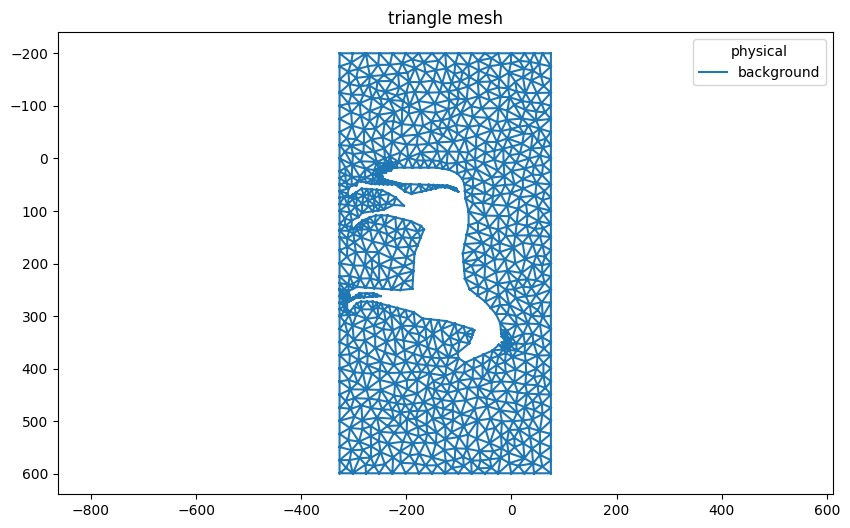

In [4]:
import numpy as np

triangles = nanomesh_mesh.get('triangle')
triangles.purge(label=2, key='physical')

triangles.points = np.flip(triangles.points, axis=1)
triangles.points[:,1] = -triangles.points[:,1]

triangles.plot()

### Running SfePy the easy way

At this stage, the data can also be saved to SfePy-supported data type, and run using the command-line options.

In [5]:
triangles.write('horse.vtk')

VTK requires 3D points, but 2D points given. Appending 0 third component.


### Running Sfepy the interactive way

To run SfePy in the Jupyter notebook, we need to set up the config interactively.

The next cell sets up the config for SfePy.

The `problem_desc` class essentially defines what is known as the [**problem description file**](https://sfepy.org/doc-devel/users_guide.html#problem-description-file).

The mesh from Nanomesh is converted using the `mesh_hook`.

In [6]:
from sfepy.discrete.fem.meshio import UserMeshIO
from sfepy.discrete.fem import Mesh

def mesh_hook(mesh, mode):
    if mode == 'read':
        points = triangles.points

        cells = triangles.cells
        cell_data = triangles.cell_data['physical']
        cell_description = ['2_3']

        mesh = Mesh.from_data(
            'triangle',
            points,
            None,  
            [cells],
            [cell_data],
            cell_description
        )
        return mesh

xmin, ymin = triangles.points.min(axis=0)
xmax, ymax = triangles.points.max(axis=0)

class problem_desc:
    __file__ = 'nanomesh'  # dummy value
    filename_mesh = UserMeshIO(mesh_hook)

    # 2D vector defining far field velocity
    v0 = np.array([
        [-1.0],
        [0.0],
    ])

    materials = {
        'm': (
            {
                'v0': v0
            },
        ),
    }

    regions = {
        'Omega': 'all',
        'Gamma_Left': (f'vertices in (x < {xmin+0.1})', 'facet'),
        'Gamma_Right': (f'vertices in (x > {xmax-0.1})', 'facet'),
        'Gamma_Top': (f'vertices in (y > {ymax-0.1})', 'facet'),
        'Gamma_Bottom': (f'vertices in (y < {ymax+0.1})', 'facet'),
        'Vertex': ('vertex in r.Gamma_Left', 'vertex'),
    }

    fields = {
        'u': ('real', 1, 'Omega', 1),
    }

    variables = {
        'phi': ('unknown field', 'u', 0),
        'psi': ('test field', 'u', 'phi'),
    }

    # these EBCS prevent the matrix from being singular, see description
    ebcs = {
        'fix': ('Vertex', {'phi.0': 0.0}),
    }

    integrals = {
        'i': 2,
    }

    equations = {
        'Laplace equation':
            """dw_laplace.i.Omega( psi, phi )
             = dw_surface_ndot.i.Gamma_Left( m.v0, psi )
             + dw_surface_ndot.i.Gamma_Right( m.v0, psi )
             + dw_surface_ndot.i.Gamma_Top( m.v0, psi )
             + dw_surface_ndot.i.Gamma_Bottom( m.v0, psi )"""
    }

    solvers = {
        'ls': ('ls.scipy_direct', {}),
        'newton': ('nls.newton', {
            'i_max': 5,
            'eps_a': 1e-16,
        }),
    }

from sfepy.base.conf import ProblemConf

conf = ProblemConf.from_module(problem_desc)

sfepy: left over: ['__module__', '__file__', 'filename_mesh', 'v0', 'materials', 'regions', 'fields', 'variables', 'ebcs', 'integrals', 'equations', 'solvers', '__dict__', '__weakref__', '__doc__', 'verbose', '_filename']


### Bonus: Accessings SfePy mesh type

Now that the config has been defined, the next cell contains a little snippet to load the SfePy mesh from the config.

In [7]:
from sfepy.discrete.fem import Mesh
trunk = conf.filename_mesh.get_filename_trunk()
mesh = conf.filename_mesh.read(Mesh(trunk))
mesh._set_shape_info()
mesh

Mesh:triangle

### Solving the PDE with FEM

Solving the partial differential equations with SfePy is straightforward:

In [8]:
from sfepy.applications import solve_pde

problem, variables = solve_pde(conf)

sfepy: reading mesh (triangle)...
sfepy: ...done in 0.00 s
sfepy: creating regions...
sfepy:     Omega
sfepy:     Gamma_Left
sfepy:     Gamma_Right
sfepy:     Gamma_Top
sfepy:     Gamma_Bottom
sfepy:     Vertex
sfepy: ...done in 0.01 s
sfepy: equation "Laplace equation":
sfepy: dw_laplace.i.Omega( psi, phi )
             = dw_surface_ndot.i.Gamma_Left( m.v0, psi )
             + dw_surface_ndot.i.Gamma_Right( m.v0, psi )
             + dw_surface_ndot.i.Gamma_Top( m.v0, psi )
             + dw_surface_ndot.i.Gamma_Bottom( m.v0, psi )
sfepy: using solvers:
                ts: no ts
               nls: newton
                ls: ls
sfepy: updating variables...
sfepy: ...done
sfepy: setting up dof connectivities...
sfepy: ...done in 0.03 s
sfepy: matrix shape: (1038, 1038)
sfepy: assembling matrix graph...
sfepy: ...done in 0.00 s
sfepy: matrix structural nonzeros: 6644 (6.17e-01% fill)
sfepy: updating variables...
sfepy: ...done
sfepy: updating materials...
sfepy:     m
sfepy: ...done in

### Plot with Mayavi

The data can be stored to a file, and then displayed in Mayavi.

Note that this will open a new window.

In [9]:
from sfepy.postprocess.viewer import Viewer

out = 'phi.vtk'

problem.save_state(out, variables)

view = Viewer(out)
view(rel_scaling=2, is_scalar_bar=True,
     is_wireframe=True, colormap='viridis')

sfepy: reading mesh (phi.vtk)...
sfepy:   number of vertices: 1185
sfepy:   number of cells:
sfepy:     2_3: 1766
sfepy: ...done in 0.01 s
sfepy: point scalars phi at [-399.5 -201.     0. ]
sfepy: range: -2.28e+03 4.74e+01 l2 norm range: 0.00e+00 2.28e+03


### Flow plot using pyvista

To view the streamlines, we use the `pv_plot` function from Sfepy. This uses `pyvista` as the renderer.

This is normally a command-line tool, so we must mimick the plotting options.

mesh from phi.vtk:
  points:  1185
  cells:   1766
  bounds:  [(-200.0, 599.0), (-327.0, 75.0), (0.0, 0.0)]
  scalars: phi, node_groups, mat_id
  steps:   1


C:\Users\Stef\miniconda3\envs\nanomesh\lib\site-packages\pyvista\core\pointset.py:201: PyvistaDeprecationWarning: You did not specify a value for `inplace` and the default value will be changing to `False` in future versions for point-based meshes (e.g., `PolyData`). Please make sure you are not assuming this to be an inplace operation.
  warnings.warn(DEFAULT_INPLACE_WARNING, PyvistaDeprecationWarning)


plot 0: phi(step 0); phi(step 0)


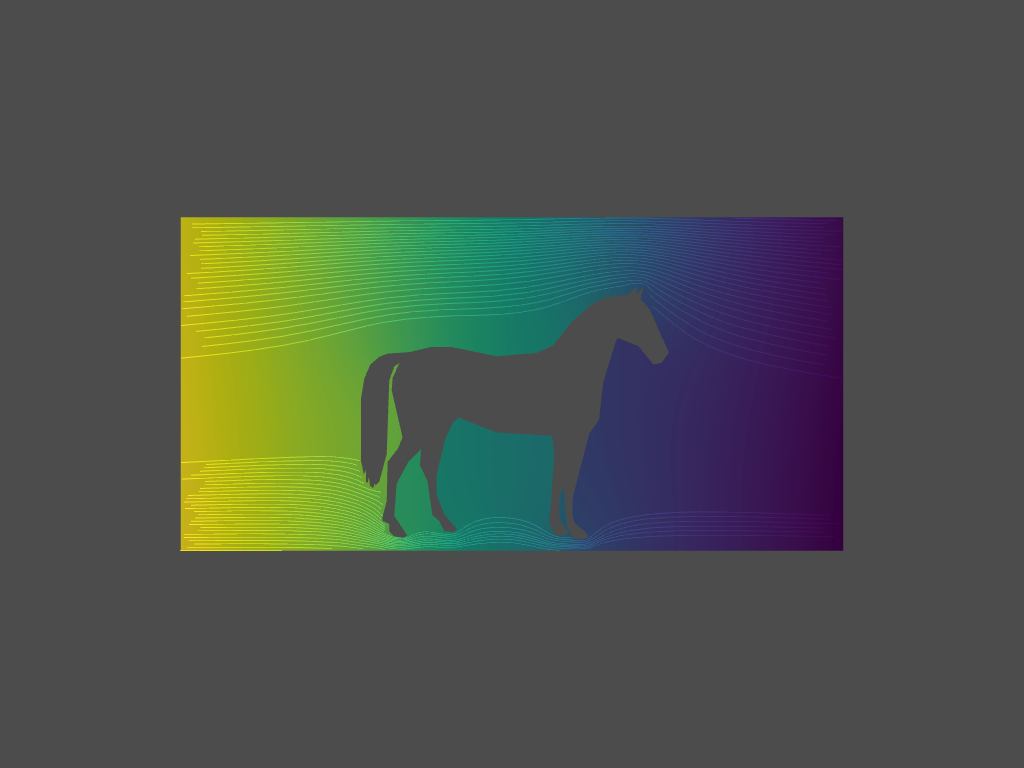

In [10]:
from resview import pv_plot

class options:
    step = 0
    view_2d = True
    position_vector = None
    fields_map = []
    fields = [
        ('phi', 'p0'),
        ('phi', 't100:p0'),
             ]
    opacity = 1.
    show_edges = False
    warp = None
    factor = 1.0
    outline = False
    color_map = None
    show_scalar_bars = False
    show_labels = False


plotter = pv_plot([out], options=options, use_cache=False)
plotter.view_xy()
plotter.show(jupyter_backend='static')

### Loading the data back into Nanomesh

The data can be loaded back into Nanomesh. Note that we must flip back the coordinates to get the correct orientation.

<AxesSubplot:title={'center':'triangle mesh'}>

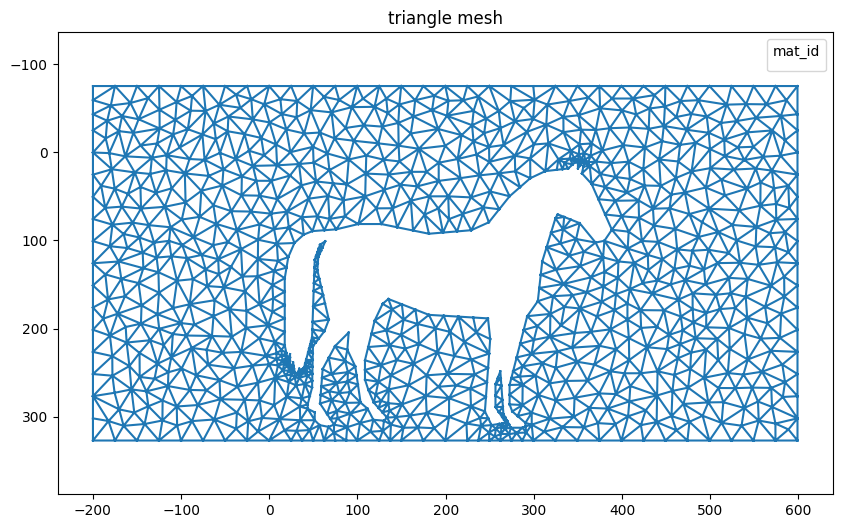

In [11]:
from nanomesh import MeshContainer

mesh_container = MeshContainer.read(out)

mesh_container.points[:,1] = -mesh_container.points[:,1]
mesh_container.points = np.flip(mesh_container.points, axis=1)

mesh_container.plot('triangle')